In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data.to_csv('cs-training1.csv', sep=',')

NameError: name 'data' is not defined

In [4]:
data = pd.read_csv('cs-training1.csv').drop('Unnamed: 0', axis = 1)

FileNotFoundError: File b'cs-training1.csv' does not exist

In [6]:
data = pd.read_csv('cs-training.csv').drop('Unnamed: 0', axis = 1)

## Initial exploration

### Data dictionary

**SeriousDlqin2yrs** Person experienced 90 days past due delinquency or worse

**RevolvingUtilizationOfUnsecuredLines**: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age**	Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse**: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

**DebtRatio**: Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome**: Monthly income

**NumberOfOpenCreditLinesAndLoans**: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate**: Number of times borrower has been 90 days or more past due.

**NumberRealEstateLoansOrLines**: Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse**: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

**NumberOfDependents**: Number of dependents in family excluding themselves (spouse, children etc.)

In [7]:
cleanCol = []
for i in range(len(data.columns)):
    cleanCol.append(data.columns[i].replace('-', ''))
    
data.columns = cleanCol

In [8]:
def removeSpecificAndPutMedian(data, first = 98, second = 96):
    New = []
    med = data.median()
    for val in data:
        if ((val == first) | (val == second)):
            New.append(med)
        else:
            New.append(val)
            
    return New

In [9]:
def add_freq():
    ncount = len(data)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

Getting a sense of how balanced or imbalanced is the outcome variable

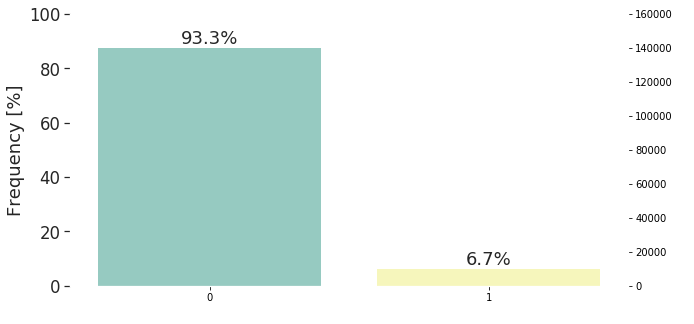

In [10]:
ax = sns.countplot(x = data.SeriousDlqin2yrs ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

add_freq()

plt.show()

### Outlier detection

In [11]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))


def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = zip(data.index, x, y, z)
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        tfOutlier = zip(x, func(x))
        nOutliers.append(len([index for (index, bol) in tfOutlier if bol == True]))
        outlierFree = [index for (index, bol) in tfOutlier if bol == True]
        sns.distplot(outlierFree, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict

def replaceOutlier(data, method = outlierVote, replace='median'):
    '''replace: median (auto)
                'minUpper' which is the upper bound of the outlier detection'''
    vote = outlierVote(data)
    x = pd.DataFrame(zip(data, vote), columns=['debt', 'outlier'])
    if replace == 'median':
        replace = x.debt.median()
    elif replace == 'minUpper':
        replace = min([val for (val, vote) in zip(data, vote) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            debtNew.append(replace)
        else:
            debtNew.append(x.iloc[i][0])
    
    return debtNew

#### RevolvingUtilizationOfUnsecuredLines var

TypeError: object of type 'zip' has no len()

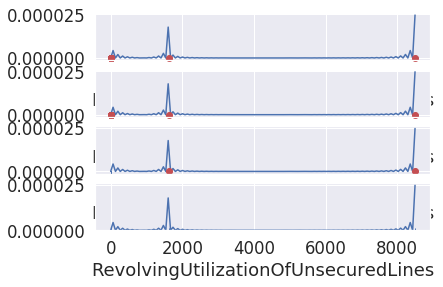

In [12]:
plotOutlier(data.RevolvingUtilizationOfUnsecuredLines.sample(1000))

The nature of the variable allows coding every extreme value as a fixed number without losing to much predictive power

In [13]:
revNew = []
for val in data.RevolvingUtilizationOfUnsecuredLines:
    if val <= 2:
        revNew.append(val)
    else:
        revNew.append(2.)

In [14]:
data.RevolvingUtilizationOfUnsecuredLines = revNew

#### Age var

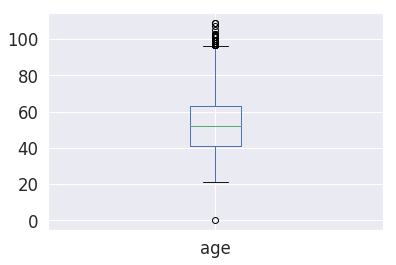

In [15]:
data.age.plot.box()

In [16]:
for i in range(16,30):
    print i, len(data[data.age < i])

SyntaxError: invalid syntax (<ipython-input-16-b1b03a8faf2f>, line 2)

22 is the youngest age in the data one outlier at 0	

In [17]:
ageNew = []
for val in data.age:
    if val > 22:
        ageNew.append(val)
    else:
        ageNew.append(22)
        
data.age = ageNew

#### NumberOfTime3059DaysPastDueNotWorse var

In [18]:
Counter(data.NumberOfTime3059DaysPastDueNotWorse)

NameError: name 'Counter' is not defined

In [19]:
New = []
med = data.NumberOfTime3059DaysPastDueNotWorse.median()
for val in data.NumberOfTime3059DaysPastDueNotWorse:
    if ((val == 98) | (val == 96)):
        New.append(med)
    else:
        New.append(val)

data.NumberOfTime3059DaysPastDueNotWorse = New

#### DebtRatio var

In [20]:
outlierRatio(data.DebtRatio)

TypeError: object of type 'zip' has no len()

TypeError: object of type 'zip' has no len()

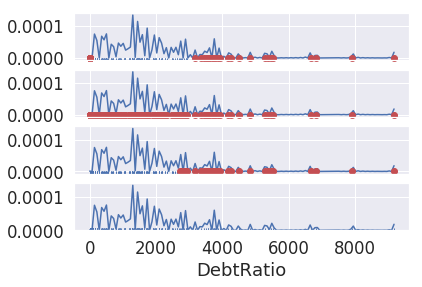

In [21]:
plotOutlier(data.DebtRatio.sample(1000))

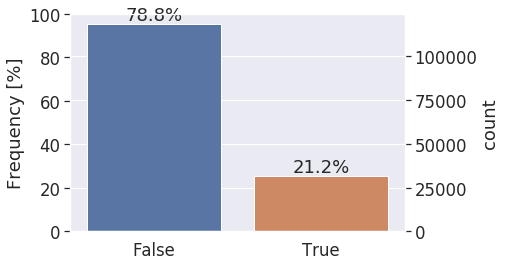

In [22]:
ax = sns.countplot(mad_based_outlier(data.DebtRatio))
add_freq()

In [23]:
minUpperBound = min([val for (val, out) in zip(data.DebtRatio, mad_based_outlier(data.DebtRatio)) if out == True])

In [24]:
newDebtRatio = []
for val in data.DebtRatio:
    if val > minUpperBound:
        newDebtRatio.append(minUpperBound)
    else:
        newDebtRatio.append(val)

In [25]:
data.DebtRatio = newDebtRatio

In [26]:
data.DebtRatio.describe()

count    150000.000000
mean          0.607359
std           0.588294
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max           1.641791
Name: DebtRatio, dtype: float64

#### Monthly income var

/anaconda3/envs/fds/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/envs/fds/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/envs/fds/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/anaconda3/envs/fds/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)
/anaconda3/envs/fds/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/anaconda3/envs/fds/lib/python3.6/site-packages/ipykernel_launcher.py

TypeError: object of type 'zip' has no len()

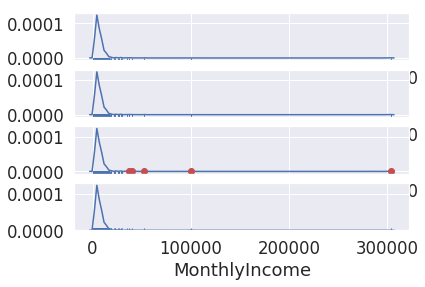

In [27]:
plotOutlier(data.MonthlyIncome.sample(1000))

In [ ]:
plotOutlierFree(data.MonthlyIncome.sample(1000))

Remove outlier from the Monthly income col by outlierVote classifier and replace them with a high fixed value

In [28]:
incomeNew = replaceOutlier(data.MonthlyIncome, replace='minUpper')

/anaconda3/envs/fds/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


TypeError: object of type 'zip' has no len()

In [29]:
data.MonthlyIncome = incomeNew

NameError: name 'incomeNew' is not defined

#### NumberOfTimes90DaysLate var

In [30]:
new = removeSpecificAndPutMedian(data.NumberOfTimes90DaysLate)

In [31]:
data.NumberOfTimes90DaysLate = new

#### NumberRealEstateLoansOrLines var

In [32]:
realNew = []
for val in data.NumberRealEstateLoansOrLines:
    if val > 17:
        realNew.append(17)
    else:
        realNew.append(val)

In [33]:
data.NumberRealEstateLoansOrLines = realNew

#### NumberOfTime6089DaysPastDueNotWorse var

In [34]:
new = removeSpecificAndPutMedian(data.NumberOfTime6089DaysPastDueNotWorse)

In [35]:
data.NumberOfTime6089DaysPastDueNotWorse = new

#### NumberOfDependents var

In [36]:
depNew = []
for var in data.NumberOfDependents:
    if var > 10:
        depNew.append(10)
    else:
        depNew.append(var)

In [37]:
data.NumberOfDependents = depNew

## NA count

In [38]:
from collections import Counter

In [39]:
def naCount(data):
    naCount = {}
    for col in data.columns:
        colNa = 0
        for val in data[col].isnull():
            if val == True:
                colNa += 1
        naCount[col] = [colNa, '{:0.2f}%'.format((float(colNa)/len(data))*100)]

    return naCount

In [40]:
def cvDictGen(functions, scr, X_train=X_train, y_train=y_train, cv=3, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[cvDict.keys()[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[cvDict.keys()[0]][1]))]
    return cvDictNormalized

NameError: name 'X_train' is not defined

NumberOfDependents NA replacment

In [41]:
depNew = []
med = data.NumberOfDependents.median()
for val in data.NumberOfDependents:
    if val.is_integer() == False:
        depNew.append(med)
    else:
        depNew.append(val)

In [42]:
data.NumberOfDependents = depNew

#### Build a model to predict NA values from the data and plug them in

In [43]:
train = data[data.MonthlyIncome.isnull() == False]
test = data[data.MonthlyIncome.isnull() == True]

In [44]:
train.shape, test.shape

((120269, 11), (29731, 11))

In [45]:
X_train = train.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)
y_train = train.MonthlyIncome
X_test = test.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import RandomizedSearchCV 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [47]:
lmMod = LinearRegression(fit_intercept=True, normalize=True).fit(X_train, y_train)

In [48]:
adaMod = AdaBoostRegressor(base_estimator=None, n_estimators=100, learning_rate=1.0, loss='linear')

In [49]:
gbMod = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=300, subsample=1.0, min_samples_split=2,
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, init=None,
                                  random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None,
                                  warm_start=False)

In [50]:
rfMod = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True,
                              oob_score=False, n_jobs=1, random_state=None, verbose=1)

In [51]:
knnMod = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30,
                             p=2, metric='minkowski', metric_params=None)

Normalize the CV scores

In [52]:
cvDictNormalize(cvDict)

NameError: name 'cvDictNormalize' is not defined

#### Replace NA in monthly income with the predicted values from the linear regression as it did pretty well compared to the other, more computationly expencive models

In [53]:
pred = lmMod.predict(X_test)

In [54]:
predNoZero = []
for val in pred:
    if val >= 0:
        predNoZero.append(val)
    else:
        predNoZero.append(0.)

In [55]:
testFull = data[data.MonthlyIncome.isnull() == True]

In [56]:
testFull['MonthlyIncome'] = predNoZero

/anaconda3/envs/fds/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
monNew = []
for index in data.index:
    if data.MonthlyIncome[index].is_integer() == True:
        monNew.append(data.MonthlyIncome[index])
    else:
        monNew.append(testFull.MonthlyIncome[index])

In [58]:
data.MonthlyIncome = monNew

## Train-Test split

In [59]:
from sklearn.cross_validation import train_test_split

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [60]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

NameError: name 'train_test_split' is not defined

## PCA

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
sScaler = StandardScaler(copy=True, with_mean=True, with_std=True)

xScaled = sScaler.fit_transform(X_train)

forPca = pd.DataFrame(xScaled)

from sklearn.decomposition import PCA

pcaMod = PCA(n_components=2)

xPca = pcaMod.fit_transform(X)

xPcaDataframe = pd.DataFrame(xPca, columns=['PC1', 'PC2'])

xPcaDataframe['cat'] = y

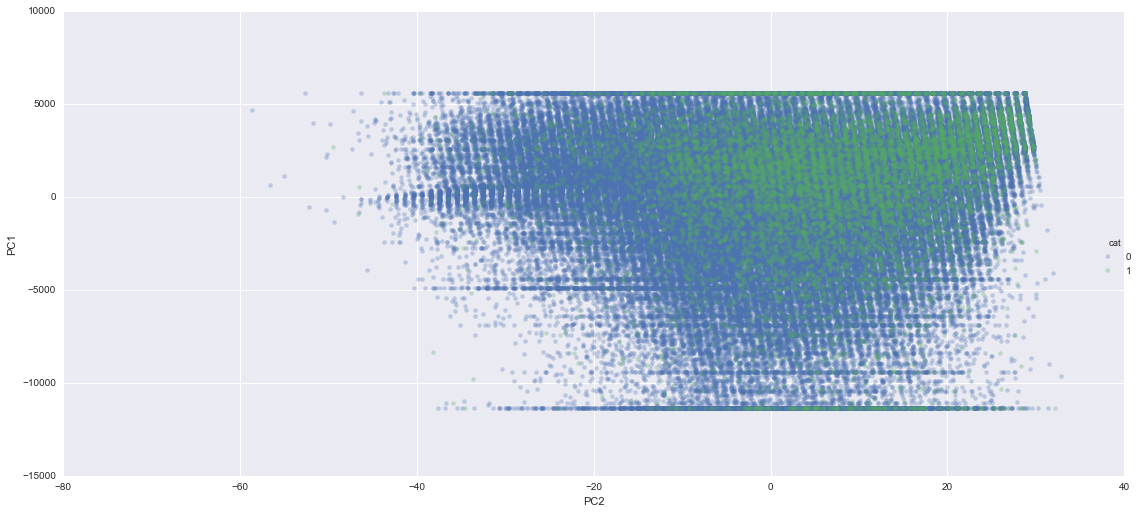

In [66]:
ax = sns.lmplot(data = xPcaDataframe, x='PC2', y='PC1', hue='cat', size=10, aspect=20, fit_reg=False,
               scatter_kws={'alpha': 0.3})
fig = plt.gcf()
fig.set_size_inches(15, 7)

## LDA

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import minmax_scale

In [10]:
xScaled = minmax_scale(X, feature_range=(0, 1))

In [31]:
ldaMod = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', priors=None, n_components=2,
                                    store_covariance=False, tol=0.0001)

In [36]:
fittedLdaMod = ldaMod.fit(xScaled, y).transform(xScaled)

ldaDf = pd.DataFrame(fittedLdaMod, columns=['one', 'two'])

ldaDf['cat'] = y

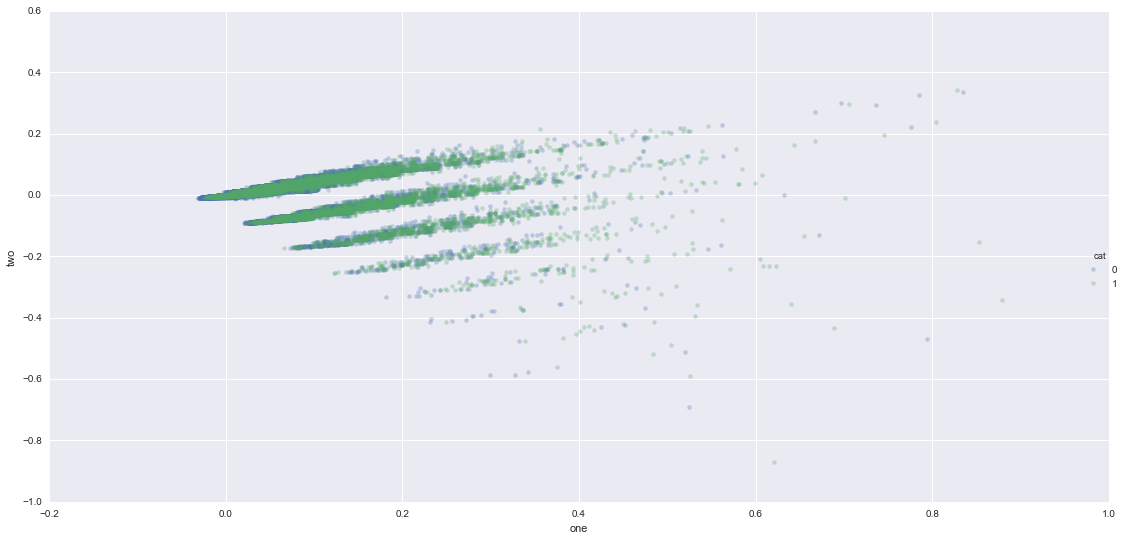

In [50]:
ax = sns.lmplot(data = ldaDf, x='one', y='two', hue='cat', size=30, aspect=5, fit_reg=False, scatter_kws={'alpha': 0.3})
fig = plt.gcf()
fig.set_size_inches(15, 7)

#### Add shrinkage

In [53]:
ldaModS = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', priors=None, n_components=2,
                                    store_covariance=False, tol=0.0001)

In [54]:
fittedLdaModS = ldaModS.fit(xScaled, y).transform(xScaled)

ldaDfS = pd.DataFrame(fittedLdaModS, columns=['one', 'two'])

ldaDfS['cat'] = y

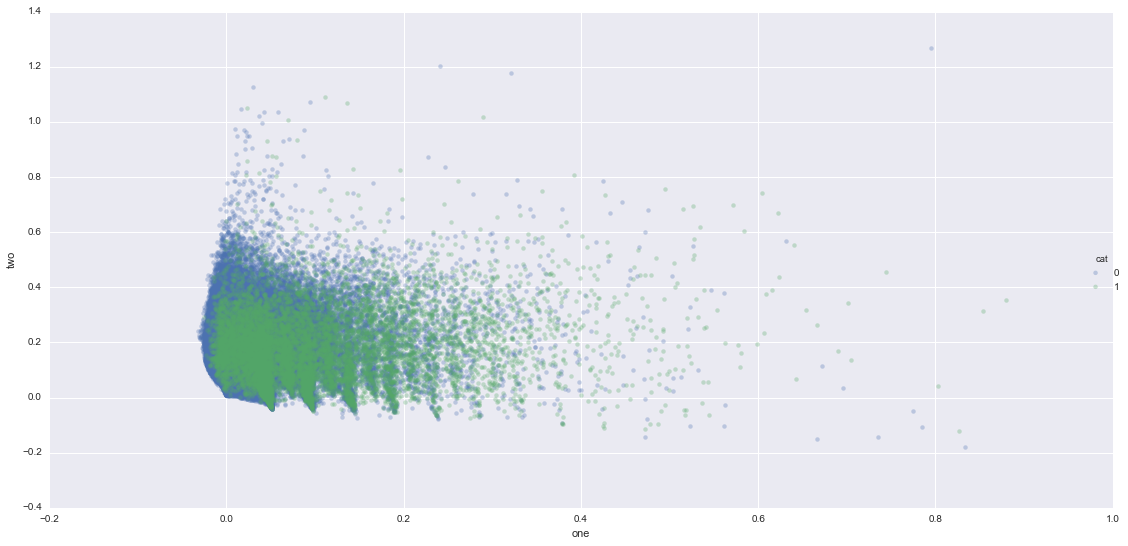

In [57]:
ax = sns.lmplot(data = ldaDf, x='one', y='two', hue='cat', size=50, aspect=5, fit_reg=False, scatter_kws={'alpha': 0.3})
fig = plt.gcf()
fig.set_size_inches(15, 7)

## t-SNE

In [5]:
from sklearn.manifold import TSNE
import random

In [6]:
tsneMod = TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, learning_rate=50., n_iter=500,
               metric='euclidean', init='random', verbose=2, random_state=None)

In [7]:
n = 7000
X_data, X_none, y_data, y_none = train_test_split(X, y, test_size=(1-(n/float(len(data)))))

In [ ]:
xTsne = tsneMod.fit_transform(X_data)

In [9]:
xTsneDataFrame = pd.DataFrame(xTsne, columns=['one', 'two'])

y_data.index = range(0,len(xTsneDataFrame))

xTsneDataFrame['cat'] = y_data

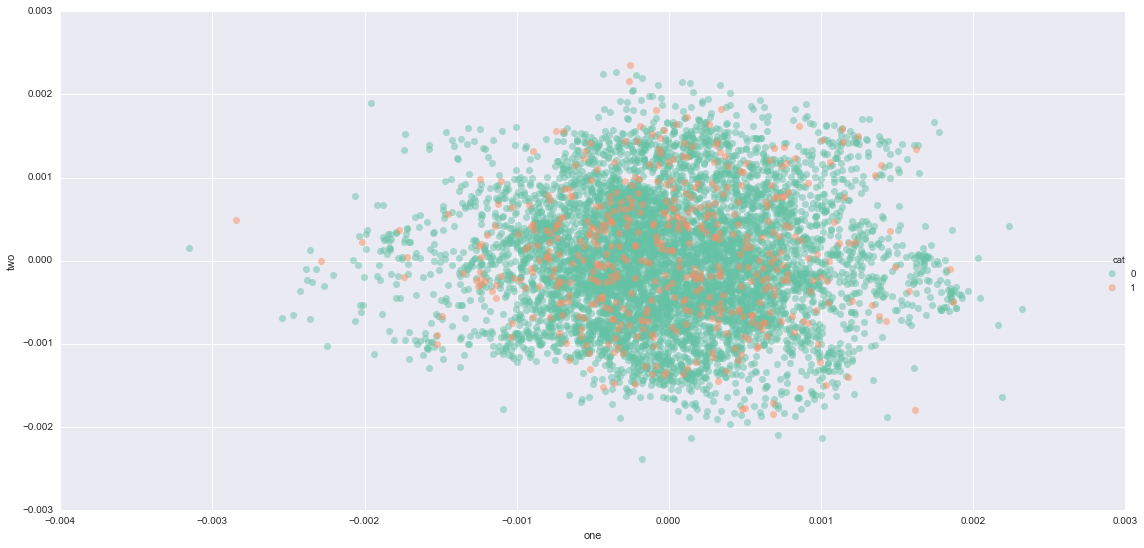

In [10]:
ax = sns.lmplot(data = xTsneDataFrame, x='one', y='two', hue='cat', size=70, aspect=5, fit_reg=False, palette='Set2',
               scatter_kws={"s": 50, 'alpha': 0.5})
fig = plt.gcf()
fig.set_size_inches(15, 7)

## Making predictions

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [17]:
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)

In [11]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)

In [71]:
adaMod = AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=1.0)

In [72]:
gbMod = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)

In [12]:
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0)

In [ ]:
cvD = cvDictGen(functions=[knMod, glmMod, adaMod, gbMod, rfMod], scr='roc_auc')

In [30]:
cvDictNormalize(cvD)

{'AdaBoostClassifier': ['1.10', '0.26'],
 'GradientBoostingClassifier': ['1.11', '0.24'],
 'KNeighborsClassifier': ['0.74', '0.92'],
 'LogisticRegression': ['1.09', '0.11'],
 'RandomForestClassifier': ['1.00', '1.00']}

GB and ADA seem to preform the best out-of-the-box

## Hyper parameter optimization

In [93]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint

Ada model

In [81]:
adaHyperParams = {'n_estimators': [10,50,100,200,400]}

In [ ]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

In [92]:
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 400}, 0.93501333333333336)

GB model

In [94]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [ ]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

In [98]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'loss': 'exponential', 'max_depth': 3, 'n_estimators': 160},
 0.86214816194432597)

Fit the best GB and ADA models

In [101]:
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [102]:
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [ ]:
cvDictHPO = cvDictGen(functions=[bestGbModFitted, bestAdaModFitted], scr='roc_auc')

In [110]:
cvDictNormalize(cvDictHPO)

{'AdaBoostClassifier': ['1.00', '1.00'],
 'GradientBoostingClassifier': ['1.01', '1.08']}

## Plot ROC curve with CV

**plotCvRocCurve** will plot the CV ROC curve with nfolds

**rocZeroOne** will compute the best cut-off point for the classifiers

In [111]:
def plotCvRocCurve(X, y, classifier, nfolds=5):
    
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold
    import matplotlib.pyplot as plt
    from scipy import interp

    cv = StratifiedKFold(y, n_folds=nfolds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CV ROC curve')
    plt.legend(loc="lower right")
    fig = plt.gcf()
    fig.set_size_inches(15,5)

    plt.show()

def rocZeroOne(y_true, y_predicted_porba):
    
    from sklearn.metrics import roc_curve
    from scipy.spatial.distance import euclidean
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted_porba[:, 1])
    
    best = [0, 1]
    dist = []
    for (x, y) in zip(fpr, tpr):
        dist.append([euclidean([x,y], best)])

    bestPoint = [fpr[dist.index(min(dist))], tpr[dist.index(min(dist))]]
    
    bestCutOff1 = thresholds[list(fpr).index(bestPoint[0])]
    bestCutOff2 = thresholds[list(tpr).index(bestPoint[1])]
    
    print '\n' + 'Best point on the ROC: TPR = {:0.3f}%, FPR = {:0.3f}%'.format(bestPoint[1]*100, bestPoint[0]*100)
    print '\n' + 'Best Cut-Off point: {:0.4f}'.format(bestCutOff1)

    plt.plot(dist)
    plt.xlabel('Index')
    plt.ylabel('Euclidean Distance to the perfect [0,1]')
    fig = plt.gcf()
    fig.set_size_inches(15,5)

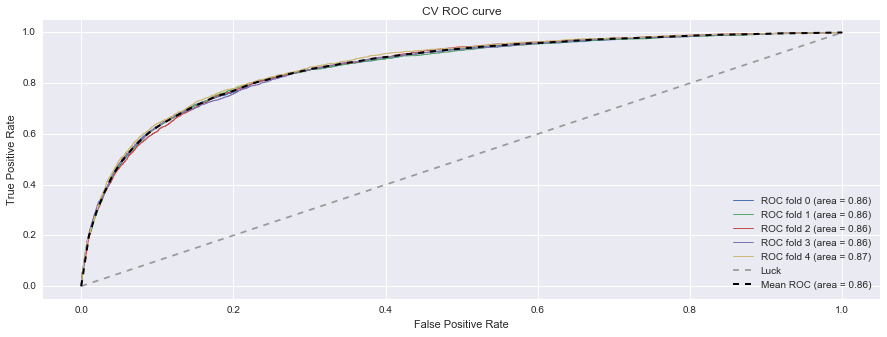

In [112]:
plotCvRocCurve(X, y, gridSearchGB.best_estimator_)


Best point on the ROC: TPR = 80.088%, FPR = 20.703%

Best Cut-Off point: 0.0645


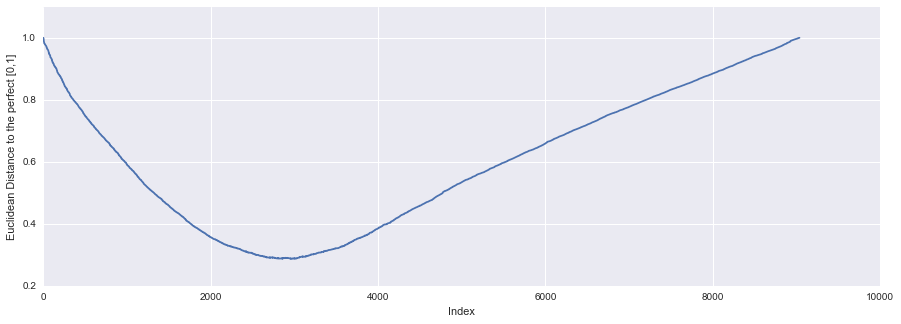

In [114]:
rocZeroOne(y_test, bestGbModFitted.predict_proba(X_test))

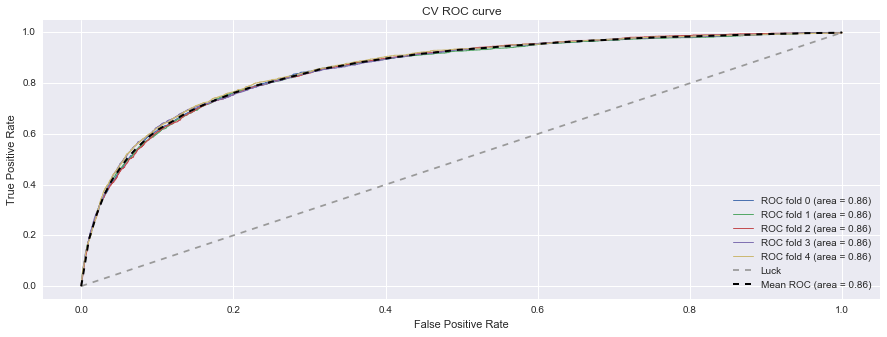

In [119]:
plotCvRocCurve(X, y, gridSearchAda.best_estimator_)


Best point on the ROC: TPR = 80.570%, FPR = 22.026%

Best Cut-Off point: 0.4982


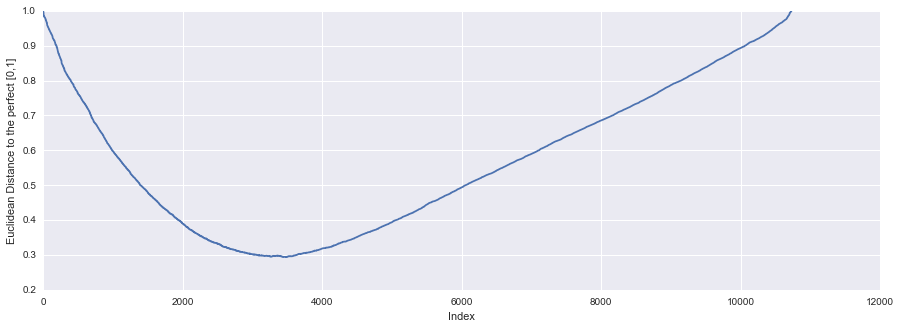

In [120]:
rocZeroOne(y_test, bestAdaModFitted.predict_proba(X_test))

## Confusion matrix

In [7]:
def plot_confusion_matrix(y_true, y_pred, title = 'Confusion matrix', cmap=plt.cm.Blues):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print 'Classification Report:\n'
    print classification_report(y_test, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    def plot_confusion_matrix_plot(cm, title = 'Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(y_test.unique()))
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    print '\n Confusion matrix, without normalization: \n'
    print cm
    plot_confusion_matrix_plot(cm=cm)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('\n Normalized confusion matrix \n')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix_plot(cm_normalized, title='Normalized confusion matrix')

def makePredThresh(fittedCls, thr = 0.5, X_test=X_test):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

Make predicions from the GB model with the optimal threshold calculated before 

In [117]:
pred = makePredThresh(bestGbModFitted, thr=0.0645)

Classification Report:

             precision    recall  f1-score   support

          0       0.98      0.79      0.88     35009
          1       0.22      0.80      0.34      2491

avg / total       0.93      0.79      0.84     37500


 Confusion matrix, without normalization: 

[[27762  7247]
 [  498  1993]]

 Normalized confusion matrix 

[[ 0.79299609  0.20700391]
 [ 0.19991971  0.80008029]]


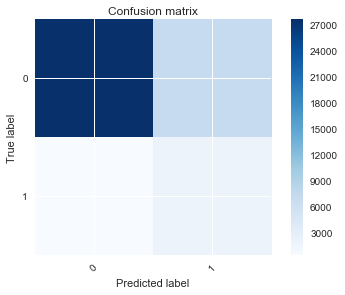

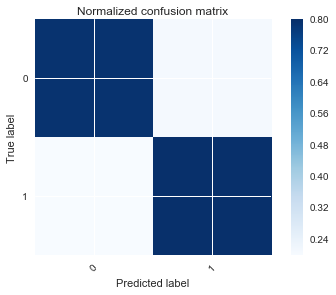

In [118]:
plot_confusion_matrix(y_test, pred)

Make predictions from the ADA model

In [121]:
predAda = makePredThresh(bestAdaModFitted, thr=0.4982)

Classification Report:

             precision    recall  f1-score   support

          0       0.98      0.77      0.86     35009
          1       0.20      0.82      0.32      2491

avg / total       0.93      0.77      0.83     37500


 Confusion matrix, without normalization: 

[[26866  8143]
 [  457  2034]]

 Normalized confusion matrix 

[[ 0.76740267  0.23259733]
 [ 0.18346046  0.81653954]]


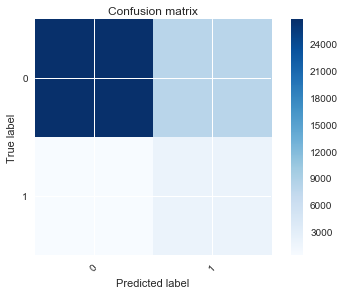

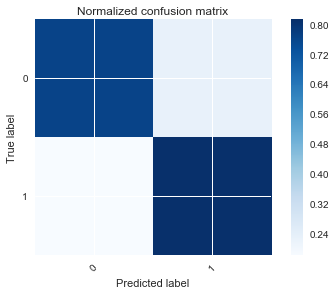

In [122]:
plot_confusion_matrix(y_test, predAda)